## Multiview ICA results

In [109]:
import numpy as np
from pathlib import Path
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

import sys
from collections import defaultdict

sys.path.append("../")
from src.tools.utils import get_files, get_h5

%load_ext autoreload
%autoreload 2
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [63]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_07-03-15:33/")
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
data_dict = get_h5(base_dir, flag="_multiviewica")

<IPython.core.display.Javascript object>

In [64]:
data_dict.keys()

dict_keys(['source', 'unmixing', 'state', 'trait', 'subject'])

<IPython.core.display.Javascript object>

In [126]:
subjs = data_dict["subject"]
states = data_dict["state"]
traits = data_dict["trait"]
signals = np.asarray(
    [
        S.T @ np.linalg.inv(Un).T
        for S, Un in zip(data_dict["source"], data_dict["unmixing"])
    ]
)

<IPython.core.display.Javascript object>

In [137]:
(np.linalg.inv(data_dict["unmixing"][0]) @ data_dict["source"][0]).T[0]

array([ 1.26702279e+04, -1.25384724e+01, -1.81300830e+01,  5.77328175e-01,
       -1.15844070e+00, -2.84752378e+00, -4.06449011e+00, -2.47082442e-01])

<IPython.core.display.Javascript object>

In [120]:
group_labels = np.asarray([[t, s] for t, s in zip(traits, states)])
groups = np.unique(group_labels, axis=0)

<IPython.core.display.Javascript object>

In [77]:
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

<IPython.core.display.Javascript object>

In [28]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

<IPython.core.display.Javascript object>

In [111]:
external_dir = Path("../data/external")


def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed=1,
    title=None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(
        n_embed,
        4,
        subplot_kw={"projection": "3d"},
        figsize=(res_scale * 5, res_scale * n_embed),
    )
    if n_embed == 1:
        axes = [axes]

    plt.subplots_adjust(wspace=0, hspace=0)

    for i, ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / "lh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[: len(cortex_left)]

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu",
            axes=ax[0],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu",
            view="medial",
            axes=ax[1],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        cortex_right = nib.freesurfer.read_label(external_dir / "rh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left) :]

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=False,
            cmap="RdBu",
            axes=ax[2],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=colorbar,
            cmap="RdBu",
            view="medial",
            axes=ax[3],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f"{str(save_path)}.png", format="png", bbox_inches="tight")
    else:
        return fig


#         plt.show()
#         plt.close(fig)


def make_cbar(vmax, save_path=None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    # cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")

    # cb1.set_clim(vmin, vmax)
    # cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f"{str(save_path)}.pdf", bbox_inches="tight")
    plt.close(fig)

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

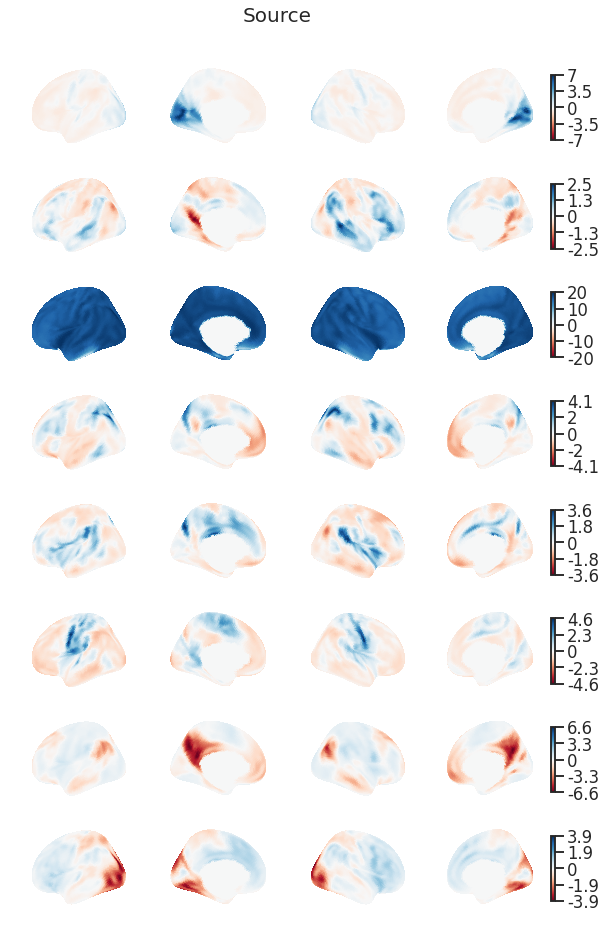

<IPython.core.display.Javascript object>

In [125]:
visualize_embeddings(
    data_dict["source"][0].T, save_path=False, colorbar=True, n_embed=8, title="Source",
)
plt.show()

<Figure size 432x288 with 0 Axes>

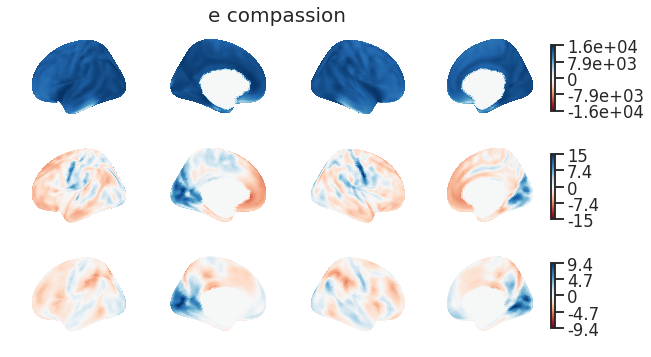

<Figure size 432x288 with 0 Axes>

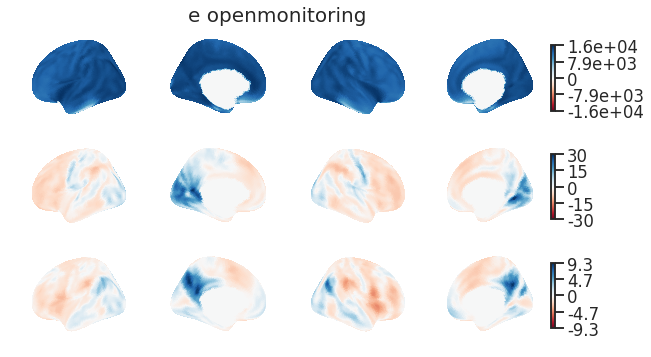

<Figure size 432x288 with 0 Axes>

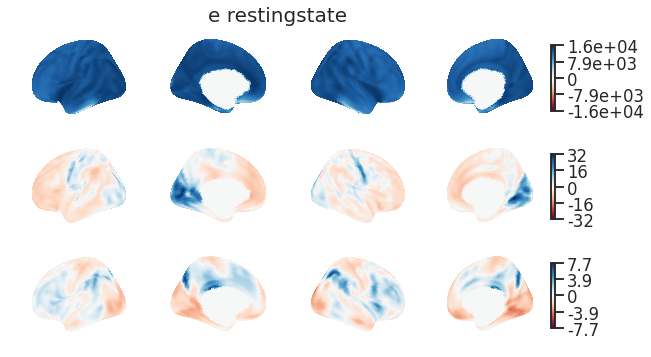

<Figure size 432x288 with 0 Axes>

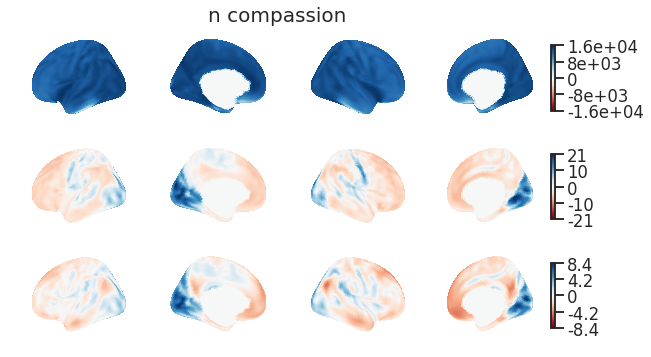

<Figure size 432x288 with 0 Axes>

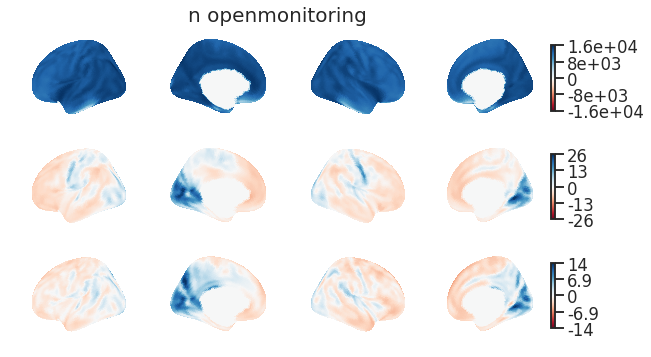

<Figure size 432x288 with 0 Axes>

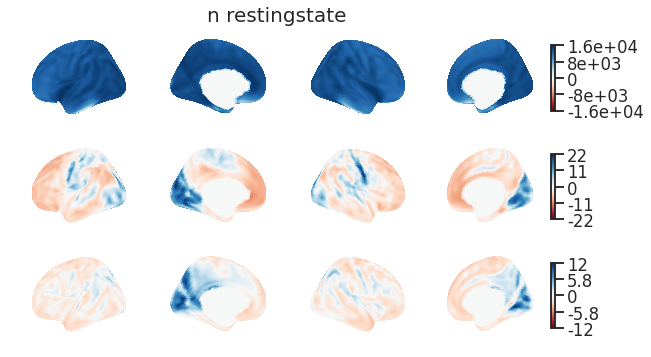

<IPython.core.display.Javascript object>

In [139]:
means = []
for group in groups:
    idxs = np.where((group_labels == group).all(axis=1))[0]
    means.append(signals[idxs].mean(axis=0))

vmax = None#max([np.max(np.abs(g)) for g in means])
SAVE = False
COLORBAR = True

for name, mean in zip(groups, means):
    if SAVE:
        title = False
    else:
        title = " ".join(name)
    visualize_embeddings(
        mean, save_path=False, colorbar=COLORBAR, n_embed=3, vmax=vmax, title=title,
    )

    if SAVE:
        # plt.savefig(save_dir / f"{name}_sig_diff_gradients.pdf", bbox_inches="tight")
        plt.show()
    else:
        plt.show()

# if SAVE and not COLORBAR:
#     make_cbar(vmax, save_dir / "sig_diffs_gradients_colorbar")